# Fake News Classification and Exploration

The last few years have seen an explosion in our collective conversations concerning fake news and what can be done to combat it.  Date scientists have taken up this challenge, as can be seen in online data science challenges(http://www.fakenewschallenge.org/), and recent initiatives by Facebook(https://techcrunch.com/2016/11/14/facebook-fake-news/).

In relation to my own data science experiences, text analysis is an unexplored phase space.  This makes an anaylsis of fake news both timely and relevant.  At a first glance, I realize this project will not be perfect in its scope or results, but that is ok.  The main metric for usefulness will be the learning experience with text classificaton, and how a simple, naive model performs this task of fake news classification.  This process will be a springboard for more complex text-based analysis, which is encapsulated in the idiom: you must learn to walk before you can run.

### Initial model
Naive Bayes Classifier using count vectorized word embeddings.

### Data
Fake news will be taken from Kaggle's public repository here:  https://www.kaggle.com/mrisdal/fake-news.  
Real news articles is "scraped" from a news aggretor: https://www.allsides.com/, as well as traditional sources such as CNN, NYT, FOX, and WAPO.  Please see the separate notebook for scraping of real news text: https://github.com/dcurry09/FakeNews_Classifier/blob/master/Scraper_RealNews.ipynb

### A few exploratory exercises on the Kaggle fake news dataset and scraped real news.

We will begin by looking at relationships among a few of the non-text features(likes, comments, URL, etc).  Before any initial training is done we should always become familair with our dataset.  We will tokenize the text and look at word frequency and semantic relationships using Word2Vec.


In [1]:
# import dependencies
%matplotlib inline
import csv as csv
import numpy as np
import pandas as pd
import pylab as py
import operator
import re, os, progressbar
import sys
import nltk
from pprint import *
from sklearn.manifold import TSNE
import multiprocessing
import codecs
import gensim.models.word2vec as w2v
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix, f1_score
#import plot_tools as myplt
from sklearn.externals import joblib
from operator import itemgetter
import pickle
import logging

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



#### Import the Data
Take a first look with describe(). Note no text or irregular entries are shown with describe(), but they are present in our dataframe.
Keep only english language articles.


In [2]:
fake_data = pd.read_csv('data/fake.csv')
fake_data = fake_data[fake_data.language == 'english']
fake_data.dropna(axis=0, inplace=True, subset=['text'])
#fake_data = fake_data.sample(frac=1.0)
fake_data.reset_index(drop=True,inplace=True)
fake_data.describe()

# Now the Real Data
real_data = pd.read_csv('data/real_news.csv')
real_data = real_data[fake_data.language == 'english']
real_data.dropna(axis=0, inplace=True, subset=['text'])
#real_data = real_data.sample(frac=1.0)
real_data.reset_index(drop=True,inplace=True)

# Add category names(Fake, Real) to their respective dataset
fake_data['class'] = 0
real_data['class'] = 1

# Combine the real and fake for training(to be used later on).  We will randomize the fake and real sets together.
fake_and_real_data = pd.concat([fake_data, real_data]).sample(frac=1.0)
#fake_and_real_data = pd.concat([fake_data, real_data])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.



We can verify that text and title are present:


In [3]:
fake_data.head(10)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,...,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,class
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,...,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,...,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,...,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,...,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,...,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0
5,8f30f5ea14c9d5914a9fe4f55ab2581772af4c31,0,Barracuda Brigade,2016-11-02T16:31:28.550+02:00,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,english,2016-11-02T16:31:28.550+02:00,100percentfedup.com,US,...,Hillary Goes Absolutely Berserk On Protester A...,0.000,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias,0
6,d3cc0fe38f41a59f7c48f8c3528ca5f74193148f,0,Fed Up,2016-11-04T19:40:00.000+02:00,BREAKING! NYPD Ready To Make Arrests In Weiner...,BREAKING! NYPD Ready To Make Arrests In Weiner...,english,2016-11-05T02:13:46.065+02:00,100percentfedup.com,US,...,BREAKING! NYPD Ready To Make Arrests In Weiner...,0.701,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0
7,b4bbf8b5c19e8864f5257832a58b81ef4ed2d4e4,0,Fed Up,2016-11-05T01:19:00.000+02:00,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,BREAKING! NYPD Ready To Make Arrests In Weiner...,english,2016-11-05T05:59:07.458+02:00,100percentfedup.com,US,...,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,0.188,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0
8,a19aabaa5a61eb8bc22fadaaa003e5fbba5c4bf6,0,Fed Up,2016-11-06T23:54:00.000+02:00,BREAKING: CLINTON CLEARED...Was This A Coordin...,\nLimbaugh said that the revelations in the Wi...,english,2016-11-07T10:20:06.409+02:00,100percentfedup.com,US,...,BREAKING: CLINTON CLEARED...Was This A Coordin...,0.144,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0
9,f54d8e13010d0a79893995ee65360ad4b38b5a35,0,Fed Up,2016-11-07T02:43:00.000+02:00,"EVIL HILLARY SUPPORTERS Yell ""F*ck Trump""…Burn...",Email \nThese people are sick and evil. They w...,english,2016-11-07T10:20:27.252+02:00,100percentfedup.com,US,...,"EVIL HILLARY SUPPORTERS Yell ""F*ck Trump""…Burn...",0.995,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,0



Before we engage the vectorization/tokenization of our text, let us look at the like/comment relationship features to see if any useful information can be extracted.  Low comment to share/like ratio could be an indicator of a fake news article under the assumption that malicious bots would "push" fake articles without commenting more often than real articles.  However, our describe() output from above indicates that comment and like features are nearly constant at zero, making them not that useful for finding correlations.  We can verify this visually below.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1197b5860>]], dtype=object)

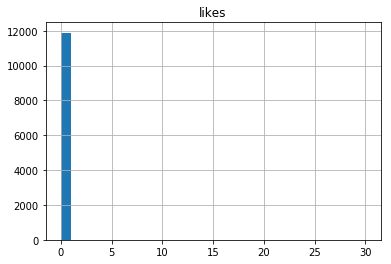

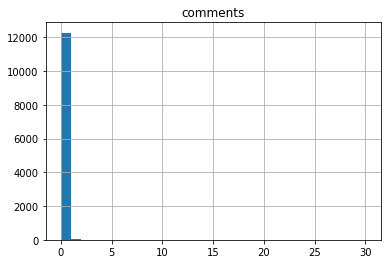

In [4]:
fake_data.hist(column='likes', bins=30, range=(0,30))
fake_data.hist(column='comments', bins=30, range=(0,30))

## Count Vectorization
From here on out we will focus on the text portions of the dataset.
Tokenizing the text of article using sci-kits Count Vectorizer(bag of words methodolgy):

In [5]:
# Fake
count_vect = CountVectorizer()
fake_matrix_CV = count_vect.fit_transform(fake_data['text'].values.astype('U'))
fake_features  = count_vect.get_feature_names()

# Real
rcount_vect = CountVectorizer(stop_words="english")
real_matrix_CV = rcount_vect.fit_transform(real_data['text'].values.astype('U'))

CountVectorizer supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:

In [6]:
count_vect.vocabulary_.get(u'algorithm')
rcount_vect.vocabulary_.get(u'algorithm')

2054

The index value of a word in the vocabulary is linked to its frequency in the whole training text.  Below is a scrollable list of our fake news vocabulary.

In [7]:
fake_vocab = count_vect.vocabulary_
real_vocab = rcount_vect.vocabulary_ 

Now, what does out count vectorized text look like?  What are the dimensions of the input word vectors?  According to the sci-kit manual:

   > Convert a collection of text documents to a matrix of token counts.  This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
   
   > Returns: sparse matrix, [n_samples, n_features]
Document-term matrix.

The question is what is n_features in the context of word frequencies(n_samples is how many articles of text we have parsed)?  Here is an example on one sentence:


> docs = ["You can catch more flies with honey than you can with vinegar.",
>          "You can lead a horse to water, but you can't make him drink."]

> vect = CountVectorizer()

> X = vect.fit_transform(docs)

> print(DataFrame(X.A, columns=vect.get_feature_names()).to_string())

>   but  can  catch  drink  flies  him  honey  horse  lead  make  more  than  to  vinegar  water  with  you

>  0     0    2      1      0      1    0      1      0     0     0     1     1   0        1      0     2    2

>  1    1    2      0      1      0    1      0      1     1     1     0     0   1        0      1     0    2

The two output rows are our two document texts(dont let the fact that they are also single sentences confuse you).    Each unique word in the full text(2 sentences here) is allotted a column slot.  Entries are frequencies.  SO each unique word is a feature with value equal to its' frequency.

Now examine the most frequent words.  Perhaps we have a glut of useless words, ie, and/of/is/what.  I dont want to presume these will be useless in fake vs real classification, perhaps they indeed are, but for the purposes of looking at the highest frequnecy of words that contain information, I want to ignore these.

In [8]:
# Sort by frequency in the text
vocab_sorted = [v[0] for v in sorted(fake_vocab.items(), key=operator.itemgetter(1))]
fdist_fake_vocab = freq_distribution = Counter(dict(zip(vocab_sorted, np.ravel(fake_matrix_CV.sum(axis=0)))))
fdist_fake_vocab.most_common(10)

[('the', 475677),
 ('to', 224463),
 ('of', 223824),
 ('and', 207159),
 ('in', 150494),
 ('that', 112641),
 ('is', 101255),
 ('for', 72590),
 ('it', 67022),
 ('on', 60145)]

Indeed, lots of filler words.  Lets clean the text up(I did this by adding to the Count Vectorizer: stop_words="english").

In [9]:
count_vect = CountVectorizer(stop_words="english")
fake_matrix_CV = count_vect.fit_transform(fake_data['text'].values.astype('U'))

## Comparing Real and Fake Word Frequencies
The power of this classification model will come from correlations between word frequencies and class label that differ between the real and fake datasets.  We will now look at comparisons between the highest word frequencies in our two datasets.  What we learn here will help us make a few educated guesses on where our predictive power comes from.

So far what we really examined above is occurence rate(raw number of word counts in all texts regardless of document length), but a more relevant metric could be the normalized occurence rate. This process is called "Term Frequency times Inverse Document Frequency" and is described next. Larger documents will have higher average count values than shorter documents, and so looking at the previous plot we might conclude that triclocarbon is highly correlated with fake news compared to the word rubble. However, this conclusion might be false if documents containing triclocarbon happen to be very long and repetitive. We would need to account for the size of the document in which the word occurs, as well as how spread put the word occurence in all documents is.
There is no gurantee apriori that TFIDF will be benificial to our model. Inuitively, it makes sense to at least look both TFIDF and then compare to non-TFIDF performance.

I will also utilize this new section to develop a system of functions to analyze a TFIDF set of documents with different class labels(ie, real and fake).  We will now look at the mean score across all documents.  This is another way to look at the average power or correlation that a word will have per document, and is not necessarily the same as total frequency.

In [10]:
# Combined Fake and Real Datasets
tfidf_transformer = TfidfTransformer()
count_vect = CountVectorizer(stop_words="english")
realfake_matrix_CV = count_vect.fit_transform(fake_and_real_data['text'].values.astype('U'))
realfake_matrix_tfidf = tfidf_transformer.fit_transform(realfake_matrix_CV)
targets = fake_and_real_data['class'].values
#count_vect.vocabulary_.get(u'algorithm')
combine_vocab = count_vect.vocabulary_
feature_list = [word for word in combine_vocab.keys()] 
features = count_vect.get_feature_names()

In [11]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.
    '''

    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'CV']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' 
    Top tfidf features in specific document (matrix row) 
    '''
    
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. 
        Xtr = tfidf array
        features = names from vocab(list)
    '''
    
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_sum_feats(Xtr, features, grp_ids=None, top_n=25):
    ''' Return the top n features that are the most frequent amongst documents in rows
        indentified by indices in grp_ids. 
        Xtr = tfidf array
        features = names from vocab(list)
    '''
    
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    tfidf_sums = np.sum(D, axis=0)
    return top_tfidf_feats(tfidf_sums, features, top_n)

print(top_mean_feats(realfake_matrix_CV, features))
print('\n\n')
print(top_sum_feats(realfake_matrix_CV, features))

       feature        CV
0       number  2.009532
1        trump  1.891336
2       people  1.629634
3         said  1.627202
4      clinton  1.598080
5          new  1.121483
6         like  1.053708
7      hillary  1.050815
8         just  1.043321
9         time  0.931699
10       world  0.858993
11   president  0.853602
12       state  0.814094
13  government  0.747108
14    election  0.730607
15        2016  0.681567
16       years  0.676111
17    american  0.661057
18         war  0.659808
19       obama  0.657441
20      states  0.614055
21        year  0.613069
22       media  0.597292
23        news  0.586116
24        know  0.580989



       feature     CV
0       number  30569
1        trump  28771
2       people  24790
3         said  24753
4      clinton  24310
5          new  17060
6         like  16029
7      hillary  15985
8         just  15871
9         time  14173
10       world  13067
11   president  12985
12       state  12384
13  government  11365
14    election  1

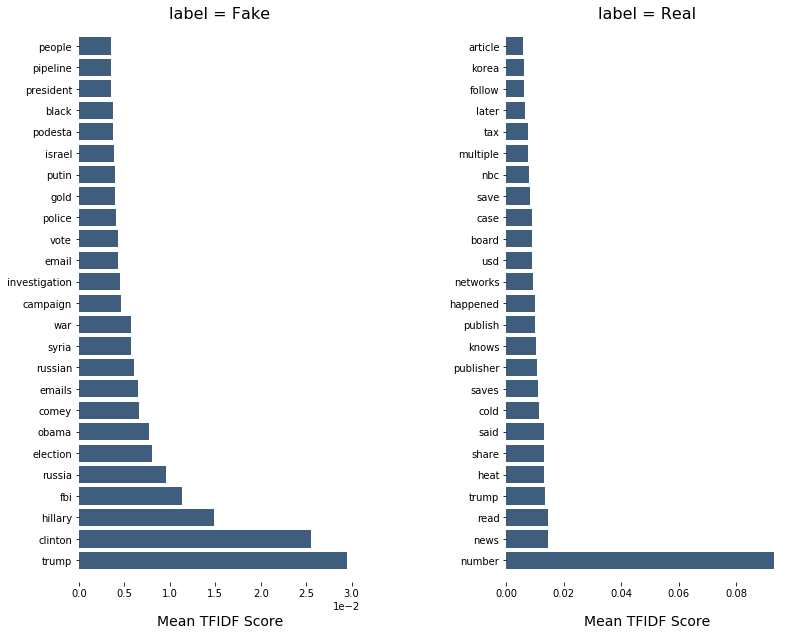

In [12]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label.
        Xtr = tfidf array
        features = names from vocab(list)
        y = class labels(fake or real)
    '''
    
    dfs = []
    labels = np.unique(y)
    #print(labels)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        
        if label == 0:
            feats_df.label = 'Fake'
        else: feats_df.label = 'Real'
             
        
        dfs.append(feats_df)
    return dfs

df_class_list = top_feats_by_class(realfake_matrix_tfidf, targets, features)

def plot_tfidf_classfeats_h(dfs, title):
    ''' Plot the data frames returned by the function top_feats_by_class(). 
    '''
    
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean "+title+" Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.CV, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.savefig('word_freq_compare_'+title+'.pdf')
    plt.show()
    
plot_tfidf_classfeats_h(df_class_list, 'TFIDF')

What can see is that the Fake and Real classes contain mostly different words which will provide 
good discriminationg power. 

Now we can also look at the non-tdif rankings

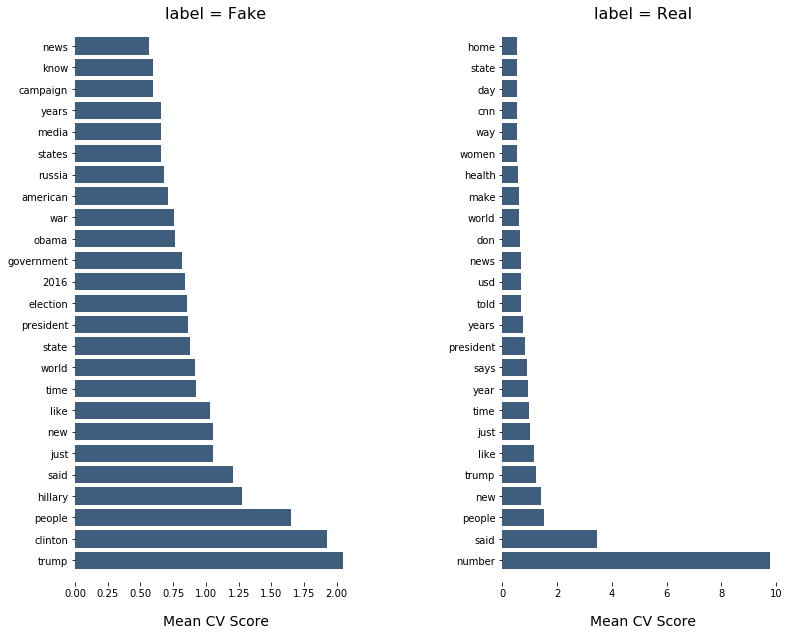

In [13]:
df_CV_class_list = top_feats_by_class(realfake_matrix_CV, targets, features)
plot_tfidf_classfeats_h(df_CV_class_list, 'CV')

## First Look at Text Classification with a Naive Bayes Classifier
MultinomialNB from sci-kit implements the naive Bayes algorithm for multinomially distributed data(where data are typically represented as word vector counts).  In order to efficiently implement different trainings and optimizations we will develop a pipeline using sci-kit's pipeline package. 

In [35]:
# Create Pipelines to Validate

CV_pipeline = Pipeline([
    ('CountVectorizer',  CountVectorizer()),
    ('MNBclassifier',  MultinomialNB()) ])

tfidf_pipeline = Pipeline([
    ('CountVectorizer',  CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('MNBclassifier',  MultinomialNB()) ])

def class_report(conf_mat):
    tp, fp, fn, tn = confusion.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

def kfold_validate(data, pipeline):
    ''' Performs kFold Cross-Validation on text classes.
        Inputs: (pd.dataset, scikit.pipeline)
        Returns: [title, f1_scores, confusion matrix, class_report]
    '''
    
    title = [str(step) for step in pipeline.named_steps]
    title = '_'.join(title)
    print('\nK-Fold Validation on Model:', title)
    
    k_fold = KFold(n=len(data), n_folds=2)
    scores = []
    y_true = []
    y_pred = [] 
    confusion = np.array([[0, 0], [0, 0]])
    
    # Keep track of pass/fail events
    false_pos = set()
    false_neg = set()
    true_pos  = set() 
    true_neg  = set() 
        
    # For TFIDF
    #if 'tfidf' in title:
    #    tfidf_transformer = TfidfTransformer()
    #    cv = CountVectorizer()
    #    cv_matrix = cv.fit_transform(data['text'].values.astype('U'))
    #    tfidf = tfidf_transformer.fit_transform(cv_matrix)        
        
    for train_indices, test_indices in k_fold:
        
        train_text = data.iloc[train_indices]['text']
        train_y = data.iloc[train_indices]['class']

        test_text = data.iloc[test_indices]['text']
        test_y = data.iloc[test_indices]['class']
                                             
        print('\nFitting Fold...')
        
        if 'tfidf' in title:
            print('\n\tTFIDF Debug..')
            cv = CountVectorizer()
            tfidf_transformer = TfidfTransformer()
            tfidf_mnb = MultinomialNB()
            tfidf_train_text = cv.fit_transform(train_text)
            #tfidf_train_text = tfidf_transformer.fit_transform(cv_train)                           
            print('TFIDF Train Text dimensions:', tfidf_train_text.shape)
            tfidf_mnb.fit(tfidf_train_text, train_y)
        else:
            pipeline.fit(train_text, train_y)
        
        print('Making Predictions...')

        if 'tfidf' in title: 
            print('\n\tTFIDF Predict Debug..')
            tfidf_test_text = cv.transform(test_text)
            #tfidf_test_text = tfidf_transformer.transform(cv_test)
            print('TFIDF Test Text dimensions:', tfidf_test_text.shape)
            predictions = tfidf_mnb.predict(tfidf_test_text) 
        else:
            predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=0)
        scores.append(score)
        y_true.extend(test_y)
        y_pred.extend(predictions)    
        
        # Collect indices of false positive and negatives
        #test_predict = np.squeeze(pipeline.predict(test_text))
        test_predict = np.squeeze(predictions)
        fn_i = np.where((test_predict==1) & (test_y==0))[0]
        fp_i = np.where((test_predict==0) & (test_y==1))[0]
        tp_i = np.where((test_predict==0) & (test_y==0))[0]
        tn_i = np.where((test_predict==1) & (test_y==1))[0]
        false_pos.update(test_indices[fp_i])
        false_neg.update(test_indices[fn_i])
        true_pos.update(test_indices[tp_i])
        true_neg.update(test_indices[tn_i])
        
        
        
    tp, fp, fn, tn = confusion.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)    
        
    print('News Articles classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    pprint(measures)

    return [title, sum(scores)/len(scores), confusion, measures, y_true, y_pred, 
            {'fp': sorted(false_pos), 'fn': sorted(false_neg), 'tp': sorted(true_pos), 'tn': sorted(true_neg)}]


if not os.path.exists('cv_results.p'):
    cv_results = kfold_validate(fake_and_real_data, CV_pipeline)
    pickle.dump(cv_results, open('cv_results.p', 'wb')) 
else:
    cv_results = pickle.load(open('cv_results.p', 'rb'))
    print('CV Results\nConfusion Matrix')
    pprint(cv_results[2])
    pprint(cv_results[3])

if not os.path.exists('tfidf_results.p'):
    tfidf_results = kfold_validate(fake_and_real_data, tfidf_pipeline)
    pickle.dump(tfidf_results, open('tfidf_results.p', 'wb')) 
else:
    tfidf_results = pickle.load(open('tfidf_results.p', 'rb'))
    print('\nTFIDF Results\nConfusion Matrix')
    pprint(tfidf_results[2])
    pprint(tfidf_results[3])

CV Results
Confusion Matrix
array([[11908,   449],
       [  475,  2380]])
{'accuracy': 0.93925848014725222,
 'f1score': 0.96265157639450283,
 'precision': 0.96366431981872624,
 'sensitivity': 0.96164095937979488,
 'specificity': 0.84128667373630261}

K-Fold Validation on Model: CountVectorizer_tfidf_MNBclassifier

Fitting Fold...

	TFIDF Debug..
TFIDF Train Text dimensions: (7606, 79113)
Making Predictions...

	TFIDF Predict Debug..
TFIDF Test Text dimensions: (7606, 79113)

Fitting Fold...

	TFIDF Debug..
TFIDF Train Text dimensions: (7606, 80131)
Making Predictions...

	TFIDF Predict Debug..
TFIDF Test Text dimensions: (7606, 80131)
News Articles classified: 15212
Score: 0.961847784606
Confusion matrix:
[[11925   432]
 [  514  2341]]
{'accuracy': 0.93781225348409147,
 'f1score': 0.96184868527181799,
 'precision': 0.96504005826656958,
 'sensitivity': 0.95867835034970661,
 'specificity': 0.84421204471691313}


## Interpreting the Results
First there is clearly some bias in the TFIDF version that is causing the false negative rate to jump.  The CV(non-tdidf) model works very well out of the box.  I will continue to investigate why TFIDF is behaving in this manner, but I will use the CV model to move on with the analysis.

#### Metric of choice depends on our needs
* Flag the highest % of fake news submitted:  High Sensitivity(TPR)
* Avoid unfairly flagging real news:  Low FPR(1-specificity)
* Purity of flagged fake news:  High Precision

Lets look at the ROC curve to get a nice visual summary of our first confusion matrix.

In [ ]:
def roc_overlay(roc_list):
    '''Plot X roc curves on one plot
       Takes in a list of roc curves 
    '''

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    labels = []
    for i,model in enumerate(roc_list):
        print(model[2])
        fpr[i], tpr[i], _ = skmetrics.roc_curve(model[0], model[1])
        roc_auc[i] = skmetrics.auc(fpr[i], tpr[i])
        labels.append(model[2])
    
    plt.figure()
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    
    for i in range(len(roc_list)):
        if i == 0:
            plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label=labels[i]+' (area = %0.2f)' % roc_auc[i])

        if i > 0:
            plt.plot(fpr[i], tpr[i], color='darkred',
             lw=lw, label=labels[i]+' (area = %0.2f)' % roc_auc[i])
    
    plt.legend(loc="lower right")    
    plt.savefig('ROC_curve.pdf')        
    plt.show()
    
    
roc_list = [ [cv_results[4], cv_results[5], 'CV'], [tfidf_results[4], tfidf_results[5], 'TFIDF']]
#roc_list = [ [cv_results[4], cv_results[5], 'CV']]
roc_overlay(roc_list)

In [ ]:
def percent_diff_dict(x1, x2):
    '''Takes in two dictionaries and returns percent diff of the key,value pairs
    '''
    percent_diff = {}
    for (k,v), (k2,v2) in zip(x1, x2):
        percent_diff[k] = 100*(v-v2)/v2

    print('\nPercent Improvement: CV vs TFIDF')
    pprint(percent_diff)

percent_diff_dict(cv_results[3].items(), tfidf_results[3].items())    

###  Thinking About Stop Words
Until now I have been working with stop words(the, but, and) removed from all texts, but perhaps there is useful information encoded in the frequency of stop words in the fake and real data sets.  What we are training for afterall is just correlations between word frequencies and author, or intended audience, not really fake or real.  Perhaps fake news is written in a more plain, simplistic style when compared to real news from WAPO and NYT.  If this is the case then stop word frequency will contain target correlations.  Lets check.

In [ ]:
CV_pipeline_noSW = Pipeline([
    ('CountVectorizer',  CountVectorizer(stop_words="english")),
    ('MNBclassifier',  MultinomialNB())])

cv_results_withSW = kfold_validate(fake_and_real_data, CV_pipeline_noSW)

 No major change can be seen.  Stop words will be included in the parameter search space just in case it is dependent on the n-gram parameter.

### First Optimization
We will now do a small hyperparameter search of the MNB training parameters

In [ ]:
# Define MNB parameters


parameters = {'CountVectorizer__ngram_range': [(1, 1), (1, 2), (1,3), (1,4), (1,5)],
              'CountVectorizer__stop_words':(None, 'english'),
               #'tfidf__use_idf': (True, False),
              'MNBclassifier__alpha': (1, 0, 1e-1, 1e-2, 1e-3, 1e-4),
              'MNBclassifier__fit_prior':(True, False)}

def grid_search_MNB(pipeline, data, parameters):
    '''Takes in a pipeline, dataset, and set of parameters to optimize.
        Returns best performing parameters by ROC AUC.
    '''

    gs = GridSearchCV(pipeline, parameters, n_jobs=-1)    

    gs = gs.fit(data['text'][:1000], data['class'][:1000])
        
    print('Best F1 Score:', gs.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs.best_params_[param_name]))
    
# Send it to the pipeline for Grid Search(sci-kits hyperparameter search module)
#grid_search_MNB(CV_pipeline, fake_and_real_data, parameters)

# Best F1 Score: 0.92
# CountVectorizer__ngram_range: (1, 5)
# CountVectorizer__stop_words: 'english'
# MNBclassifier__alpha: 0.01
# MNBclassifier__fit_prior: True


In [ ]:
# Now implement the best hyperparameters
CV_pipeline_optimized = Pipeline([
    ('CountVectorizer',  CountVectorizer(stop_words="english", ngram_range=(1, 5))),
    ('MNBclassifier',  MultinomialNB(alpha=0.01, fit_prior=True))])

if not os.path.exists('cv_results_optmized.p'):
    cv_results_optmized = kfold_validate(fake_and_real_data, CV_pipeline_optimized)
    pickle.dump(cv_results_optmized, open('cv_results_optmized.p', 'wb')) 
else:
    cv_results_optmized = pickle.load(open('cv_results_optmized.p', 'rb'))
    print('CV Results\nConfusion Matrix')
    pprint(cv_results_optmized[2])
    pprint(cv_results_optmized[3])

In [ ]:
# Plot ROC before and after optimization
roc_list = [ [cv_results[4], cv_results[5], 'Out-of-Box'], [cv_results_optmized[4], cv_results_optmized[5], 'Optimized']]       
roc_overlay(roc_list)

percent_diff_dict(cv_results[3].items(), cv_results_optmized[3].items())

## Understanding the performance of our model
Let's keep track of which documents are failed to be classified correctly and inspect the most frequent words in those documents.  There may be a pattern that can help us improve the accuracy.

In [ ]:
def plot_df_col_horiz(dfs, title):
    '''Creates horizontal bar histogram of a dataframe column for a df'''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs))   
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Score", labelpad=16, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.barh(x, dfs.CV, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    yticks = ax.set_yticklabels(dfs.feature)
    plt.savefig('word_freq_'+title+'.pdf')
    plt.show()
    

df_CV_FN = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fn'])
plot_df_col_horiz(df_CV_FN, 'False Negatives')

df_CV_FP = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fp'])
plot_df_col_horiz(df_CV_FP, 'False Positives')

df_CV_TP = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tn'])
plot_df_col_horiz(df_CV_TP, 'True Positives')

df_CV_TN = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tp'])
plot_df_col_horiz(df_CV_TN, 'True Negatives')

Looking at the top words in different confusion matrix elements does not reveal enough insight into what is happening in the articles that fail.  We are going to have to dig deeper into the data by applying clustering techniques that will help us visualize word relationships and hopefully illuminate how model is behaving.

## Word2Vec

Up to this point we had considered our data in word "chunks", that is we broke each sentence into individual parts. In doing so we may have lost a bit of descriptive due to ignoring the holistic nature of words within the document from which it came. Now we will look at words in the context of the sentences in which they reside. To do so we will use the NLTK package for cleaning and tokenization by sentence.
Once sentences have been tokenized we will use Word2vec to cluster words together and to find patterns within sentences and documents. Developed at Google, Word2Vec is an unsupervised 2-layer neural network that uses backpropagation to assign probabilites for each word to occur near another for in a given interval. 

The relevant output of the shallow NN is the weight matrix of the hidden layer.  This matrix works essentially as a look-up table for any word given as input.  The output for any word input will be a word vector corresponding to that
word and whose entries are probabilities to be found near other words.  Through this method we can cluster words together by looking for similarities between the word vectors(the output of word2vec) and not the input word frequencies.

The hyperparameters of the NN are:
 * num_features is the number of dimensions we want to embed our words in (the length of the final word vectors)
 * min_word_count, if the count of a words use is below this threshold, corpus wide, ignore the word
 * context_size is the window size left and right of the target word to consider words


In [ ]:
def sent_token(text):
    text = nltk.sent_tokenize(text)
    return text

def sentence_clean(text):
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if len(word)>1] # exclude 1 letter words
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_clean(sent_token(text))

In [ ]:
# Tokenize the sentences
fake_and_real_data['sent_tokenized_text'] = fake_and_real_data['text'].apply(apply_all)
all_sentences = list(fake_and_real_data['sent_tokenized_text'])
all_sentences = [subitem for item in all_sentences for subitem in item]

In [ ]:
# Word2Vec Hyperparameters
num_features = 300
min_word_count = 10
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3

all2vec = w2v.Word2Vec(
    sg=1,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [ ]:
# Train w2v
if not os.path.exists('w2v_matrix.p'):
    all2vec.build_vocab(all_sentences)
    print("Word2Vec vocabulary length:", len(all2vec.wv.vocab))
    print('\nTraining Word2Vec...')
    all2vec.train(all_sentences, total_examples=all2vec.corpus_count, epochs=all2vec.iter)
    all_word_vectors_matrix = all2vec.wv.syn0
    vocab = all2vec.wv.vocab
    pickle.dump(all_word_vectors_matrix, open('w2v_matrix.p', 'wb')) 
    pickle.dump(vocab, open('w2v_vocab.p', 'wb')) 
else:    
    all_word_vectors_matrix = pickle.load(open('w2v_matrix.p', 'rb'))
    vocab = pickle.load(open('w2v_vocab.p', 'rb'))
    print('\nLoaded Word2Vec Results...')

# Output shape
all_word_vectors_matrix.shape    

### Visualizing Word2Vec output
A common technique to visualize our newly clustered words is to use TSNE(https://lvdmaaten.github.io/tsne/). TSNE utilizes dimensionality reduction in order to visualize our embedded word relationships in a 2-D representation.
Each cluster in this plot can be thought of as a new feature that could be used for training in another algroithm. 
Instead of hundreds of thousands of unique word features, word2Vec has provided us with a reduced feature set. Whether or not this reduced feature set will provide better seperation power versus real news features will be one of the questions I will look at as this project continues. 

In [ ]:
if not os.path.exists('tsne_fit.p'):
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y_all = tsne.fit_transform(all_word_vectors_matrix)
    pickle.dump(Y_all, open('tsne_fit.p', 'wb')) 
else:
    Y_all = pickle.load(open('tsne_fit.p', 'rb'))
    print('\nLoaded TSNE Fit Results')    

In [ ]:
# Plot all words
plt.figure(figsize=(20,12))
plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10)
plt.title("TSNE Map of Word2Vec Embeddings")
plt.savefig('all_w2v_tsne.pdf')
plt.show()

In [ ]:
# Words that NLTK and sci-kit handle differently
remove_words = ['ve','doesn', 'didn', '11', 'sīrius', 'isn', 'wouldn', 'wasn', 'https', 'hasn',
               'aren', 'http', 'www', 'utm_campaign', 'utm_content', 'utm_medium', 'ims', 'utm_source',
               'tzrwu', 'infowarsstore', 'madyson', 'ivankatrump', 'gonna', 'caruana', '1980s',
               'lohuizen', 'couldn', 'steagall', 'daleiden', 'matthewamiller', 'secours', 'corless',
               'weren', '6b', 'popups', 'galindez', '21st', '8th', 'ninon', 'frannie', 'winship',
               'arteaga', 'sandbar', 'schatzgraber', 'fiancee', 'gbp', 'moraitis', 'snoo', 'beek',
               'bigbro442', 'israelism', 'b12', 'brien', 'thacker', 'multiplayer', 'klamath',
               'dieterlen', 'ru', 'hadn', 'leighty', 'boogie', '100k', 'dadayev', 'pinkney', '1st',
               'consortiumnews', '1990s', 'lizbeth', '27photos', 'pokies', 'wmw_admin', 'novella',
               'kdp', 'cecchini', 'velázquez', 'martínez', '90s', 'shouldn','fsociety', 'tencent',
               'lowey', 'mrnickharvey', 'giambruno', 'amur', 'zhong', 'trevi', 'ecpa', 'youssif',
               'hudaydah', 'stethoscopes', 'rokala', 'ww3', 'radev', 'realdonaldtrump', 'isgoc',
               'bhante', 'hananu', 'iâ', 'kaylee', 'chlamydia', 'darnell', 'cinquina', '7th', 'weiskopf',
               'hillhouse']




# Let us look at the FP case on top of all clusters to see how spread they are
plt.figure(figsize=(20,12))

# Get the top 15 FP by mean CV
df_CV_FN_25 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fn'], top_n=25)
print(df_CV_FN_25.iloc[[0]]['feature'])
df_CV_TP_25 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tp'], top_n=25)
df_CV_TN_25 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tn'], top_n=25)
df_CV_FP_25 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fp'], top_n=25)

# Find all vocab indices
index_fn = [vocab[word].index for word in df_CV_FN_25['feature'] if word not in remove_words and not word.isdigit()] 
index_tp = [vocab[word].index for word in df_CV_TP_25['feature'] if word not in remove_words and not word.isdigit()] 
index_fp = [vocab[word].index for word in df_CV_FP_25['feature'] if word not in remove_words and not word.isdigit()] 
index_tn = [vocab[word].index for word in df_CV_TN_25['feature'] if word not in remove_words and not word.isdigit()] 

# Build a new NP array
Y_FN = itemgetter(index_fn)(Y_all)
Y_TP = itemgetter(index_tp)(Y_all)
Y_TN = itemgetter(index_tn)(Y_all)
Y_FP = itemgetter(index_fp)(Y_all)

# Plot FN on top of all
plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.15)
plt.scatter(Y_FP[:,0], Y_FP[:,1], color='red', s=100, label='FP')

for label, x, y in zip(df_CV_FP_25['feature'], Y_FP[:, 0], Y_FP[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.legend(loc='upper right', numpoints=1, ncol=1, fontsize=15)
    
plt.savefig('FP_on_ALL_tsne.pdf')
plt.show()    

plt.figure(figsize=(20,12))
all = plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.15)
fp = plt.scatter(Y_FP[:,0], Y_FP[:,1], color='red', s=100)
tp = plt.scatter(Y_TP[:,0], Y_TP[:,1], color='blue', s=100)
for label, x, y in zip(df_CV_FP_25['feature'], Y_FP[:, 0], Y_FP[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')


plt.legend((fp,tp), ('FP','TP'),
           scatterpoints=1, loc='upper right', ncol=1, fontsize=15)
  
plt.savefig('FN_with_TP_tsne.pdf')
plt.show()

plt.figure(figsize=(20,12))
all = plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.15)
fp = plt.scatter(Y_FP[:,0], Y_FP[:,1], color='red', s=100)
tp = plt.scatter(Y_TP[:,0], Y_TP[:,1], color='blue', s=100)
tn = plt.scatter(Y_TN[:,0], Y_TN[:,1], color='cyan', s=100)

for label, x, y in zip(df_CV_FP_25['feature'], Y_FP[:, 0], Y_FP[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.legend((fp,tp,tn), ('FP','TP', 'TN'),
           scatterpoints=1, loc='upper right', ncol=1, fontsize=15)
  
plt.savefig('FN_with_TPandTN_tsne.pdf')
plt.show()


In [ ]:
plt.figure(figsize=(20,12))

all = plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.15)
tp = plt.scatter(Y_TP[:,0], Y_TP[:,1], color='blue', s=50)
tn = plt.scatter(Y_TN[:,0], Y_TN[:,1], color='red', s=50)

for label, x, y in zip(df_CV_TP_25['feature'], Y_TP[:, 0], Y_TP[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    
plt.legend((tp,tn),
           ('TP', 'TN'), scatterpoints=1,loc='upper right', ncol=2, fontsize=15)      
plt.savefig('TP_FN_tsne.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(20,12))

all = plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.15)
fn = plt.scatter(Y_FN[:,0], Y_FN[:,1], color='red', s=100)
tp = plt.scatter(Y_TP[:,0], Y_TP[:,1], color='blue', s=100)
tn = plt.scatter(Y_TN[:,0], Y_TN[:,1], color='cyan', s=100)
fp = plt.scatter(Y_FP[:,0], Y_FP[:,1], color='green', s=100)

for label, x, y in zip(df_CV_FN_25['feature'], Y_FN[:, 0], Y_FN[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    
plt.legend((tp,fp,fn,tn),
           ('TP', 'FP', 'FN', 'TN'),
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=15)      
plt.savefig('All_confusion_tsne.pdf')
plt.show()

In [ ]:
ntop = 500
df_CV_FN_100 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fn'], top_n=ntop)
df_CV_FP_100 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['fp'], top_n=ntop)
df_CV_TN_100 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tn'], top_n=ntop)
df_CV_TP_100 = top_mean_feats(realfake_matrix_CV, features, grp_ids=cv_results_optmized[6]['tp'], top_n=ntop)

In [ ]:
# Words that NLTK and sci-kit handle differently
remove_words = ['ve','doesn', 'didn', '11', 'sīrius', 'isn', 'wouldn', 'wasn', 'https', 'hasn',
               'aren', 'http', 'www', 'utm_campaign', 'utm_content', 'utm_medium', 'ims', 'utm_source',
               'tzrwu', 'infowarsstore', 'madyson', 'ivankatrump', 'gonna', 'caruana', '1980s',
               'lohuizen', 'couldn', 'steagall', 'daleiden', 'matthewamiller', 'secours', 'corless',
               'weren', '6b', 'popups', 'galindez', '21st', '8th', 'ninon', 'frannie', 'winship',
               'arteaga', 'sandbar', 'schatzgraber', 'fiancee', 'gbp', 'moraitis', 'snoo', 'beek',
               'bigbro442', 'israelism', 'b12', 'brien', 'thacker', 'multiplayer', 'klamath',
               'dieterlen', 'ru', 'hadn', 'leighty', 'boogie', '100k', 'dadayev', 'pinkney', '1st',
               'consortiumnews', '1990s', 'lizbeth', '27photos', 'pokies', 'wmw_admin', 'novella',
               'kdp', 'cecchini', 'velázquez', 'martínez', '90s', 'shouldn','fsociety', 'tencent',
               'lowey', 'mrnickharvey', 'giambruno', 'amur', 'zhong', 'trevi', 'ecpa', 'youssif',
               'hudaydah', 'stethoscopes', 'rokala', 'ww3', 'radev', 'realdonaldtrump', 'isgoc',
               'bhante', 'hananu', 'iâ', 'kaylee', 'chlamydia', 'darnell', 'cinquina', '7th', 'weiskopf',
               'hillhouse', 'x17online', 'x17', 'emailid', 'alzheimer', 'k2', 'usd200k', 'śâ',
               'brandless', 'weâ', 'h7n9', 'disruptj20', 'galacticconnection', '26photos', 'tion']


# Now lets highlight common words to the False Negative category
plt.figure(figsize=(20,12))

index_fn = [vocab[word].index for word in df_CV_FN_100['feature'] if word not in remove_words and not word.isdigit()] 
index_fp = [vocab[word].index for word in df_CV_FP_100['feature'] if word not in remove_words and not word.isdigit()] 
index_tn = [vocab[word].index for word in df_CV_TN_100['feature'] if word not in remove_words and not word.isdigit()] 
index_tp = [vocab[word].index for word in df_CV_TP_100['feature'] if word not in remove_words and not word.isdigit()] 

Y_FN = itemgetter(index_fn)(Y_all)
Y_FP = itemgetter(index_fp)(Y_all)
Y_TN = itemgetter(index_tn)(Y_all)
Y_TP = itemgetter(index_tp)(Y_all)


fn = plt.scatter(Y_FN[:,0], Y_FN[:,1], color='green', s=50, alpha=0.7)
fp = plt.scatter(Y_FP[:,0], Y_FP[:,1], color='cyan', s=50, alpha=0.6)
tn = plt.scatter(Y_TN[:,0], Y_TN[:,1], color='red', s=50, alpha=0.5)
tp = plt.scatter(Y_TP[:,0], Y_TP[:,1], color='yellow', s=50, alpha=0.4)
#all = plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10, alpha=0.05)

#for label, x, y in zip(all2vec.wv.vocab, Y_FP[:, 0], Y_FP[:, 1]):
#    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')    

plt.legend((tp,fp,fn,tn),
           ('TP', 'FP', 'FN', 'TN'),
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=15)      

plt.title('TSNE Map of Word2Vec Embeddings: Top 1000 for CM Elements')
plt.savefig('all_tsne_1000.pdf')
plt.show()

## Next Steps and Questions

### Gain further understanding of feature correlations
Which features are correlated with incorrect classification?  Which features are clustered together using word2vec?
Can we learn something from our text classification?  The most frequent words in Fake news articles that do not appear on Real articles could tell us something about the authors behind malicous news.

### Try more complex models
Now that we have a baseline performance metric(96% accuracy with MNB classifier), we can start looking at more complex models(RNNs, Word2Vec).  A more complex model, no matter how sexy it may sound on paper, is not worth it if we gain little in predictive power at the expense of interprebility and computation time.


### Marketing this tool with a demo
For the final step I am planning to have a demo that simulates what a company like Facebook or Reddit would want:  Here are 10 articles from NYT and 10 from Infowars, classify them.  For this I can use my scraper in real time to pick a website, scrape 10 news articles, then import, process, and evaluate the data in my pipeline. 

### Move from Fake News classification to Fake News generation
One byproduct of using an RNN to learn information in text is that we also have on hand a primer to generate new, randon text based on the what the RNN learned during its training.  This has been shown on texts ranging form Shakesspeare's works to Mathmetical research papers.  What if we wanted to build a Fake News generator, not for the purpose of disemination, but rather to anticipate and understand how the next generation of Fake news could be created.
